Updated Ml_Class_1.py so rerunning the classification algorithm compairison:

Additional algorithms are also tested this time around!

In [1]:
#Imports
import numpy as np
import pandas as pd
import sys, os, random
import importlib
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone


#Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC, NuSVC
# from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Class Import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../.."))) #Allow for imports from src
from src.models import ML_Class_1
importlib.reload(ML_Class_1) #Ensures file is uptodate!
from src.models.ML_Class_1 import Model_Tester

#Set Seed
os.environ["PYTHONHASHSEED"] = "1945"
random.seed(1945)
np.random.seed(1945)


In [3]:
#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
df.shape #Test

(1174, 21)

In [4]:
#Drop unecessary/redundent features
df = df.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df.reset_index(drop=True).head(3)

,Number of Ships,Number of Escort Ships,Number of Stragglers,Total Tons of Convoy,Overall Sink Percentage,Avg Number of U-Boats in Atlantic,Escort Ratio,Time At Sea (Days),Month,Year,Previous Month Avg Sink %,Approx. Sighting Range
0,5.0,2.0,0.0,22877.0,0.0,6.0,0.400000,3.0,9.0,1939.0,0.0,12.190200
1,5.0,2.0,0.0,22967.0,0.0,6.0,0.400000,5.0,9.0,1939.0,0.0,12.190200
2,7.0,4.0,0.0,21293.0,0.0,6.0,0.571429,5.0,9.0,1939.0,0.0,14.434062


In [5]:
#Convert Overall Sink Percentage to binary 1( High)
df['Risk'] = (df['Overall Sink Percentage'] > 0).astype(int) 
#Risk is binary based off whether a ship was sunk while in a convoy:  (0 = No Ships Sunk, 1 = At Least One Ship Sunk)
X = np.array(df.drop(columns=['Overall Sink Percentage', 'Risk'])) #Remove Overall Sink Percentage as it leaks data
y = df['Risk'].values #Prediction value

In [6]:
#Intiate and perfrom train test split on data set
base_tester = Model_Tester()
base_tester.train_test_split(X, y)

In [7]:
#Base Line Test of ALL algorthims (Phase 2)
classifiers = [
    #Linear Models:
    ("LogReg", LogisticRegression(random_state=1945, max_iter=1600)),
    ("SGDC", SGDClassifier(random_state=1945)),
    #SVM Models:
    ("LinSVC", LinearSVC(random_state=1945)),
    ("SVC", SVC(random_state=1945, probability=True)),
    ("NuSVS", NuSVC(nu=0.2, random_state=1945, probability=True)), #First attempt failed with nu=0.5, will change to nu=0.2
    #Neighbor Models
    ("KN", KNeighborsClassifier()),
    ("RN", RadiusNeighborsClassifier(radius=6)), #radius=2 picked at random Failed first time, will increase radius to 6
    #Trees & Ensembles
    ("DecT", DecisionTreeClassifier(random_state=1945)),
    ("RanF", RandomForestClassifier(random_state=1945)),
    ("ExT", ExtraTreesClassifier(random_state=1945)),
    ("Bag", BaggingClassifier(random_state=1945)),
    ("GB", GradientBoostingClassifier(random_state=1945)),
    ("AdaB", AdaBoostClassifier(random_state=1945)),
    #Naive Bayes
    ("GauNB", GaussianNB()),
    ("BerNB", BernoulliNB()),
    ("ComNb", ComplementNB()),
    #Discriminant analysis
    ("LinD", LinearDiscriminantAnalysis()),
    ("QuadD", QuadraticDiscriminantAnalysis()),
    #Sklearn Neural Network
    ("MLP NN", MLPClassifier(random_state=1945, max_iter=2000))
    ]


#Algorithms Tested:

# # Linear models
# LogisticRegression(random_state=1945, max_iter=1600)
# SGDClassifier(random_state=1945)

# # SVM family
# LinearSVC(random_state=1945)
# SVC(random_state=1945, probability=True)
# NuSVC(nu=0.2, random_state=1945, probability=True)

# # Neighbors
# KNeighborsClassifier()                
# RadiusNeighborsClassifier(radius=6)          

# # Trees and ensembles
# DecisionTreeClassifier(random_state=1945)
# RandomForestClassifier(random_state=1945)
# ExtraTreesClassifier(random_state=1945)
# BaggingClassifier(random_state=1945)
# GradientBoostingClassifier(random_state=1945)
# AdaBoostClassifier(random_state=1945)

# # Naive Bayes
# GaussianNB()      
# BernoulliNB()     
# ComplementNB()    

# # Discriminant analysis
# LinearDiscriminantAnalysis()        
# QuadraticDiscriminantAnalysis()    

# # Neural networks
# MLPClassifier(random_state=1945, max_iter=2000)

In [45]:
#Train and Evaluate Models

#Scale models which need it
scale_these = {"LogReg", "SGDC", "SVC", "NuSVS", "KN", "RN", "MLP_NN"}

results = {}
for name, clf in classifiers:
    scaler = StandardScaler() if name in scale_these else None
    tester = Model_Tester(
        model=clone(clf),
        scaler=scaler,
        cv_folds=base_tester.cv_folds,
        feature_names=base_tester.feature_names)
    tester.X_train, tester.X_test = base_tester.X_train, base_tester.X_test
    tester.y_train, tester.y_test = base_tester.y_train, base_tester.y_test
    tester.optimize() #no parameter_grid yeilds plain fit, no show_plot skips plots
    results[name] = tester.evaluate(show_plots=False)



LogisticRegression Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       185
           1       0.54      0.14      0.22        50

    accuracy                           0.79       235
   macro avg       0.67      0.55      0.55       235
weighted avg       0.75      0.79      0.74       235


ROC AUC Score: 0.7857
Matthews Correlation Coefficient (MCC): 0.1926
Balanced Accuracy: 0.5538
LogisticRegression Confusion Matrix (values only):
[[179   6]
 [ 43   7]]

SGDClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       185
           1       0.50      0.10      0.17        50

    accuracy                           0.79       235
   macro avg       0.65      0.54      0.52       235
weighted avg       0.74      0.79      0.73       235


ROC AUC Score: 0.7283
Matthews Correlation Coefficient (MCC): 0.1480

/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi


SVC Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       185
           1       0.71      0.10      0.18        50

    accuracy                           0.80       235
   macro avg       0.76      0.54      0.53       235
weighted avg       0.78      0.80      0.73       235


ROC AUC Score: 0.7679
Matthews Correlation Coefficient (MCC): 0.2147
Balanced Accuracy: 0.5446
SVC Confusion Matrix (values only):
[[183   2]
 [ 45   5]]

NuSVC Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       185
           1       0.44      0.32      0.37        50

    accuracy                           0.77       235
   macro avg       0.64      0.61      0.62       235
weighted avg       0.75      0.77      0.76       235


ROC AUC Score: 0.6671
Matthews Correlation Coefficient (MCC): 0.2408
Balanced Accuracy: 0.6059
NuSVC Confu

/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

In [ ]:
#Algorithms Tested With Scores: (Thank you to chat for collecting these results)

# Model                        Acc   ROC_AUC  MCC    Bal_Acc  Recall1  F1_1
# LogisticRegression           0.79  0.786   0.193  0.554    0.14     0.22
# SGDClassifier                0.79  0.728   0.148  0.537    0.10     0.17
# LinearSVC                    0.79  0.535   0.000  0.500    0.00     0.00
# SVC                          0.80  0.768   0.215  0.545    0.10     0.18
# NuSVC                        0.77  0.667   0.241  0.606    0.32     0.37
# KNeighborsClassifier         0.80  0.740   0.265  0.588    0.22     0.32
# RadiusNeighborsClassifier    0.78  0.567  -0.034  0.497    0.00     0.00
# DecisionTreeClassifier       0.74  0.621   0.235  0.621    0.42     0.40
# RandomForestClassifier       0.84  0.815   0.461  0.674    0.38     0.51
# ExtraTreesClassifier         0.84  0.791   0.469  0.688    0.42     0.53
# BaggingClassifier            0.83  0.766   0.400  0.656    0.36     0.47
# GradientBoostingClassifier   0.84  0.835   0.473  0.696    0.44     0.54 #Always performs the best, will test xgboost library next. 
# AdaBoostClassifier           0.82  0.790   0.368  0.631    0.30     0.42
# GaussianNB                   0.77  0.670   0.096  0.530    0.12     0.18
# BernoulliNB                  0.79  0.699   0.000  0.500    0.00     0.00
# ComplementNB                 0.49  0.555   0.061  0.537    0.62     0.34
# LinearDiscriminantAnalysis   0.79  0.787   0.205  0.561    0.16     0.25
# QuadraticDiscriminantAnalysis0.78  0.790   0.425  0.735    0.66     0.56
# MLPClassifier                0.67  0.542  -0.064  0.471    0.12     0.13

In [11]:
#Test of Gradient Descent Classifiers:

xgboostclassifiers = [
("XGBC", XGBClassifier(random_state=1945, use_label_encoder=False, eval_metric="logloss")), #avoid waring messages
("LGBMC", LGBMClassifier(random_state=1945)),
("CatB", CatBoostClassifier(random_state=1945, verbose=0)) #verbose=0 to not print every iteration
]


In [13]:
#Train and evaluate xgboost classifers:
scale_these = {}
results = {}
for name, clf in xgboostclassifiers:
    scaler = StandardScaler() if name in scale_these else None
    tester = Model_Tester(
        model=clone(clf),
        scaler=scaler,
        cv_folds=base_tester.cv_folds,
        feature_names=base_tester.feature_names)
    tester.X_train, tester.X_test = base_tester.X_train, base_tester.X_test
    tester.y_train, tester.y_test = base_tester.y_train, base_tester.y_test
    tester.optimize() #no parameter_grid yeilds plain fit, no show_plot skips plots
    results[name] = tester.evaluate(show_plots=False)

/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:37:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1755048541311/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       185
           1       0.71      0.34      0.46        50

    accuracy                           0.83       235
   macro avg       0.78      0.65      0.68       235
weighted avg       0.81      0.83      0.81       235


ROC AUC Score: 0.7728
Matthews Correlation Coefficient (MCC): 0.4084
Balanced Accuracy: 0.6511
XGBClassifier Confusion Matrix (values only):
[[178   7]
 [ 33  17]]
[LightGBM] [Info] Number of positive: 201, number of negative: 738
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 911
[LightGBM] [Info] Number of data points in the train set: 939, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.214058 -> initscore=-1.300639
[LightGBM] [Info] Start 

/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LGBMClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       185
           1       0.68      0.42      0.52        50

    accuracy                           0.83       235
   macro avg       0.77      0.68      0.71       235
weighted avg       0.82      0.83      0.82       235


ROC AUC Score: 0.7922
Matthews Correlation Coefficient (MCC): 0.4426
Balanced Accuracy: 0.6830
LGBMClassifier Confusion Matrix (values only):
[[175  10]
 [ 29  21]]

CatBoostClassifier Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       185
           1       0.81      0.34      0.48        50

    accuracy                           0.84       235
   macro avg       0.83      0.66      0.69       235
weighted avg       0.84      0.84      0.82       235


ROC AUC Score: 0.8316
Matthews Correlation Coefficient (MCC): 0.4568
Ba

In [17]:
# Model                        Acc  ROC_AUC  MCC    Bal_Acc  Recall1  F1_1
# GradientBoostingClassifier   0.84  0.835   0.473  0.696    0.44     0.54 #Still performs the best, hmmmm... 
# XGBClassifier                0.83  0.773   0.408  0.651    0.34     0.46
# LGBMClassifier               0.83  0.792   0.443  0.683    0.42     0.52
# CatBoostClassifier           0.84  0.832   0.457  0.659    0.34     0.48

#Older tests saw XGBClassifier being much better, will likley continue to test both side by side. 

Train/Test split -> train: 4500, test: 1500


/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:39:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1755048541311/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:39:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1755048541311/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:39:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1755048541311/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/minif

[xgb] optimization via grid completed in 24.67s (best_recall=0.9215).
[xgb] recall=0.9202 precision=0.9149 balanced_accuracy=0.9370


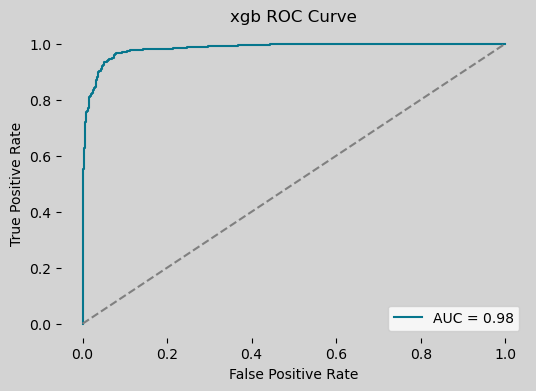

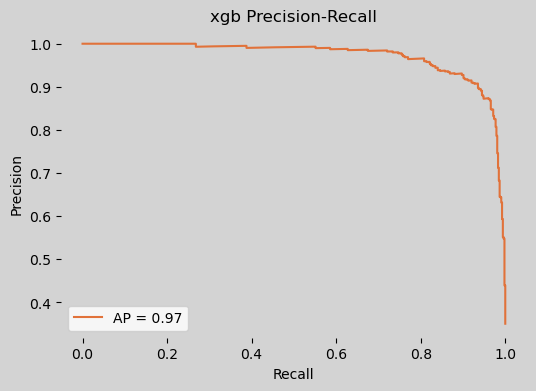

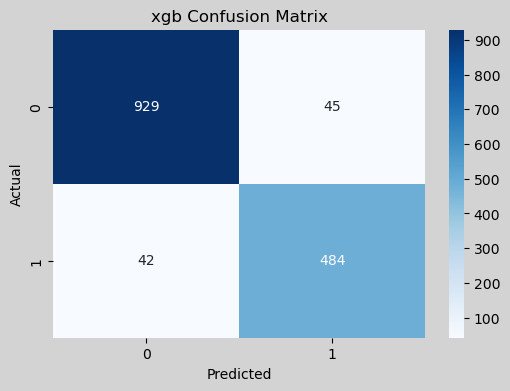

/Users/matthewplambeck/Desktop/Convoy Predictor/src/models/Model_Refiner_1.py:666: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Importance", y="Feature", data=importance_df, palette="crest_r")


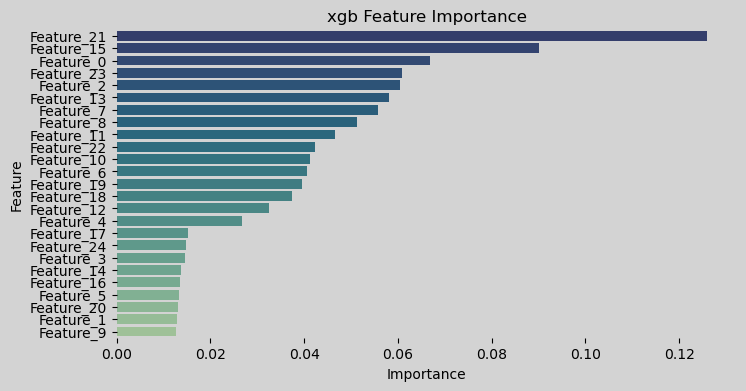

Model ranking by 'recall':
            recall
model_name        
xgb         0.9202


,recall,precision,f1,balanced_accuracy,mcc,roc_auc,average_precision,specificity,best_params,best_cv_score
model_name,,,,,,,,,,
xgb,0.920152,0.914934,0.917536,0.936975,0.872814,0.982878,0.971197,0.953799,"{'model__colsample_bytree': 0.7, 'model__learn...",0.921519


In [3]:
from sklearn.datasets import make_classification
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from src.models.Model_Refiner_1 import GradientDescentModelRefiner
from sklearn.preprocessing import StandardScaler

# 1. Build a toy dataset (replace with your convoy features/labels)
X, y = make_classification(
    n_samples=6000,
    n_features=25,
    n_informative=12,
    n_redundant=4,
    weights=[0.65, 0.35],  # mimic class imbalance
    random_state=42,
)

# 2. Configure the models you want to try (recall is optimized by default)
models_config = {
    "xgb": {
        "estimator": XGBClassifier(
            objective="binary:logistic",
            eval_metric="aucpr",
            tree_method="hist",
            scale_pos_weight=float((y == 0).sum() / (y == 1).sum()),
            random_state=42,
            use_label_encoder=False,
        ),
        "param_grid": {
            "learning_rate": [0.05, 0.1],
            "max_depth": [3, 5],
            "subsample": [0.7, 1.0],
            "colsample_bytree": [0.7, 1.0],
            "n_estimators": [200, 400],
        },
        "search_strategy": "grid",
        "fit_params": {
            "eval_set": [(X[:1000], y[:1000])],  # swap in validation data from your convoy set
            "verbose": False,
        },
    },
}

# 3. Instantiate the refiner
refiner = GradientDescentModelRefiner(
    models_config=models_config,
    cv_folds=5,
    primary_metric="recall",
    positive_label=1,
    n_jobs=-1,
    random_state=42,
    default_scaler=StandardScaler(),
    verbose=True,
)

# 4. Split data + optimize
refiner.train_test_split(X, y, train_size=0.75, stratify=True)
refiner.optimize_all()            # executes each search with recall scoring
refiner.evaluate_all(plot=True)  # set plot=True for ROC/PR/confusion/importance charts

# 5. Review recall-focused ranking
comparison_df = refiner.compare_models(metric="recall")
comparison_df.head()


In [4]:
refiner.optimization_results["xgb"]["best_params"]   # tuned hyperparameters




{'model__colsample_bytree': 0.7,
 'model__learning_rate': 0.05,
 'model__max_depth': 5,
 'model__n_estimators': 400,
 'model__subsample': 0.7}

In [5]:
refiner.evaluation_results["xgb"]["metrics"]         # recall, precision, etc.


{'recall': 0.9201520912547528,
 'precision': 0.9149338374291115,
 'f1': 0.9175355450236967,
 'balanced_accuracy': 0.9369754296109494,
 'mcc': 0.8728144209787133,
 'roc_auc': 0.9828780225013858,
 'average_precision': 0.9711965740298798}

In [6]:
refiner.compare_models(metric="recall")


Model ranking by 'recall':
            recall
model_name        
xgb         0.9202


,recall,precision,f1,balanced_accuracy,mcc,roc_auc,average_precision,specificity,best_params,best_cv_score
model_name,,,,,,,,,,
xgb,0.920152,0.914934,0.917536,0.936975,0.872814,0.982878,0.971197,0.953799,"{'model__colsample_bytree': 0.7, 'model__learn...",0.921519


In [7]:
refiner.cross_validate_model("xgb")


/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:41:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1755048541311/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:41:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1755048541311/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/miniforge/base/envs/Python-ML/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:41:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1755048541311/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/homebrew/Caskroom/minif

[xgb] CV recall mean=0.9120 ± 0.0166


{'fit_time': array([1.37067318, 1.39213681, 1.36346388, 1.38533187, 1.34492183]),
 'score_time': array([0.02730608, 0.02119303, 0.0279851 , 0.02121305, 0.02138329]),
 'test_recall': array([0.89873418, 0.92405063, 0.92405063, 0.92721519, 0.88607595]),
 'train_recall': array([1., 1., 1., 1., 1.]),
 'test_precision': array([0.92508143, 0.8902439 , 0.94193548, 0.92429022, 0.90322581]),
 'train_precision': array([0.9976322 , 0.99684543, 0.99842022, 0.99684543, 0.99605989]),
 'test_balanced_accuracy': array([0.92967531, 0.9312034 , 0.94661436, 0.94305965, 0.91735304]),
 'train_balanced_accuracy': array([0.99935788, 0.99914384, 0.99957192, 0.99914384, 0.99892979])}

In [ ]:
# Optional Follow-ups

# Call refiner.cross_validate_model("xgb") to sanity-check recall variance across folds.
# Inspect refiner.evaluation_results["sgd_log"]["metrics"] for model-specific stats or refiner.optimization_results["mlp"]["best_params"] to see tuned settings.
# Replace the synthetic dataset with your convoy features/labels, making sure to pass your actual validation split into XGBoost’s eval_set so early stopping behaves well.